# Darts regression model

In [1]:
import logging

import pandas as pd
import torch
from darts.models import RNNModel
from darts.dataprocessing.transformers import Scaler

from src.utils import prepare_col, historical_forecasts, plot_forecasts

/scale_wlg_persistent/filesets/project/nesi99999/riom/LSTM-ML-for-teeth/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_float32_matmul_precision("high")

## Data preparation

In [3]:
dset = pd.read_csv("../results/dataset_minutes.csv")
dset

,material,sample,Time [min],Line Distance [m],Wear Loss [mm]
0,G1,S1,0,0.118,-0.001950
1,G1,S1,1,0.358,-0.000967
2,G1,S1,2,0.598,-0.001717
3,G1,S1,3,0.838,-0.000992
4,G1,S1,4,1.078,-0.001683
...,...,...,...,...,...
236802,G9,S5,4162,998.998,0.162267
236803,G9,S5,4163,999.238,0.164275
236804,G9,S5,4164,999.478,0.163733
236805,G9,S5,4165,999.718,0.163325


In [4]:
dset["Time [min]"] = dset["Time [min]"] // 10
dset = dset.groupby(["material", "sample", "Time [min]"]).mean().reset_index()

In [5]:
train_materials = ["G5", "G6", "G8", "G9", "G10", "G11"]
test_materials = ["G7"]

In [6]:
dset_train = dset[dset.material.isin(train_materials)]
groups_train = dset_train.groupby(["material", "sample"])
series_train = [prepare_col(group, "Wear Loss [mm]") for _, group in groups_train]
series_train_idx = [prepare_col(group, "Time [min]") for _, group in groups_train]

scaler = Scaler().fit([series_train[0], series_train_idx[0]])
series_train_scaled, series_train_idx_scaled = zip(
    *[scaler.transform(series) for series in zip(series_train, series_train_idx)]
)

## Model training

In [7]:
pl_trainer_kwargs = {
    "enable_progress_bar": True,
    "accelerator": "gpu",
    "devices": 1,
    "gradient_clip_val": 0.2,
}

In [8]:
from darts.utils.likelihood_models import GaussianLikelihood

In [9]:
model = RNNModel(
    model="LSTM",
    input_chunk_length=100,
    training_length=400,
    hidden_dim=16,
    n_rnn_layers=2,
    dropout=0.2,
    batch_size=128,
    n_epochs=300,
    optimizer_kwargs={"lr": 1e-3},
    likelihood=GaussianLikelihood(),
    random_state=12345,
    pl_trainer_kwargs=pl_trainer_kwargs,
)

In [10]:
%%time
model.fit(
    [serie for serie in series_train_scaled if len(serie) > 400],
    future_covariates=[serie for serie in series_train_idx_scaled if len(serie) > 400],
)

/scale_wlg_persistent/filesets/project/nesi99999/riom/LSTM-ML-for-teeth/venv/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scale_wlg_persistent/filesets/project/nesi99999/rio ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 3.5 K 
4 | V             | Linear           | 34    
--------------------------------------------

Epoch 299: 100%|██████████| 4/4 [00:00<00:00, 25.54it/s, loss=-2.49, train_loss=-2.52]   

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 4/4 [00:00<00:00, 25.26it/s, loss=-2.49, train_loss=-2.52]
CPU times: user 49.8 s, sys: 1.75 s, total: 51.5 s
Wall time: 58.1 s


## Predictions

In [11]:
n_warmup = [100, 200]

In [12]:
%%time
%%capture

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

dset_pred = dset[dset.material.isin(train_materials + test_materials)]
forecasts = {
    key: historical_forecasts(model, scaler, group, n_warmup=n_warmup, n_lags=1, n_samples=50)
    for key, group in dset_pred.groupby(["material", "sample"])
}

CPU times: user 6.5 s, sys: 556 ms, total: 7.06 s
Wall time: 7.18 s


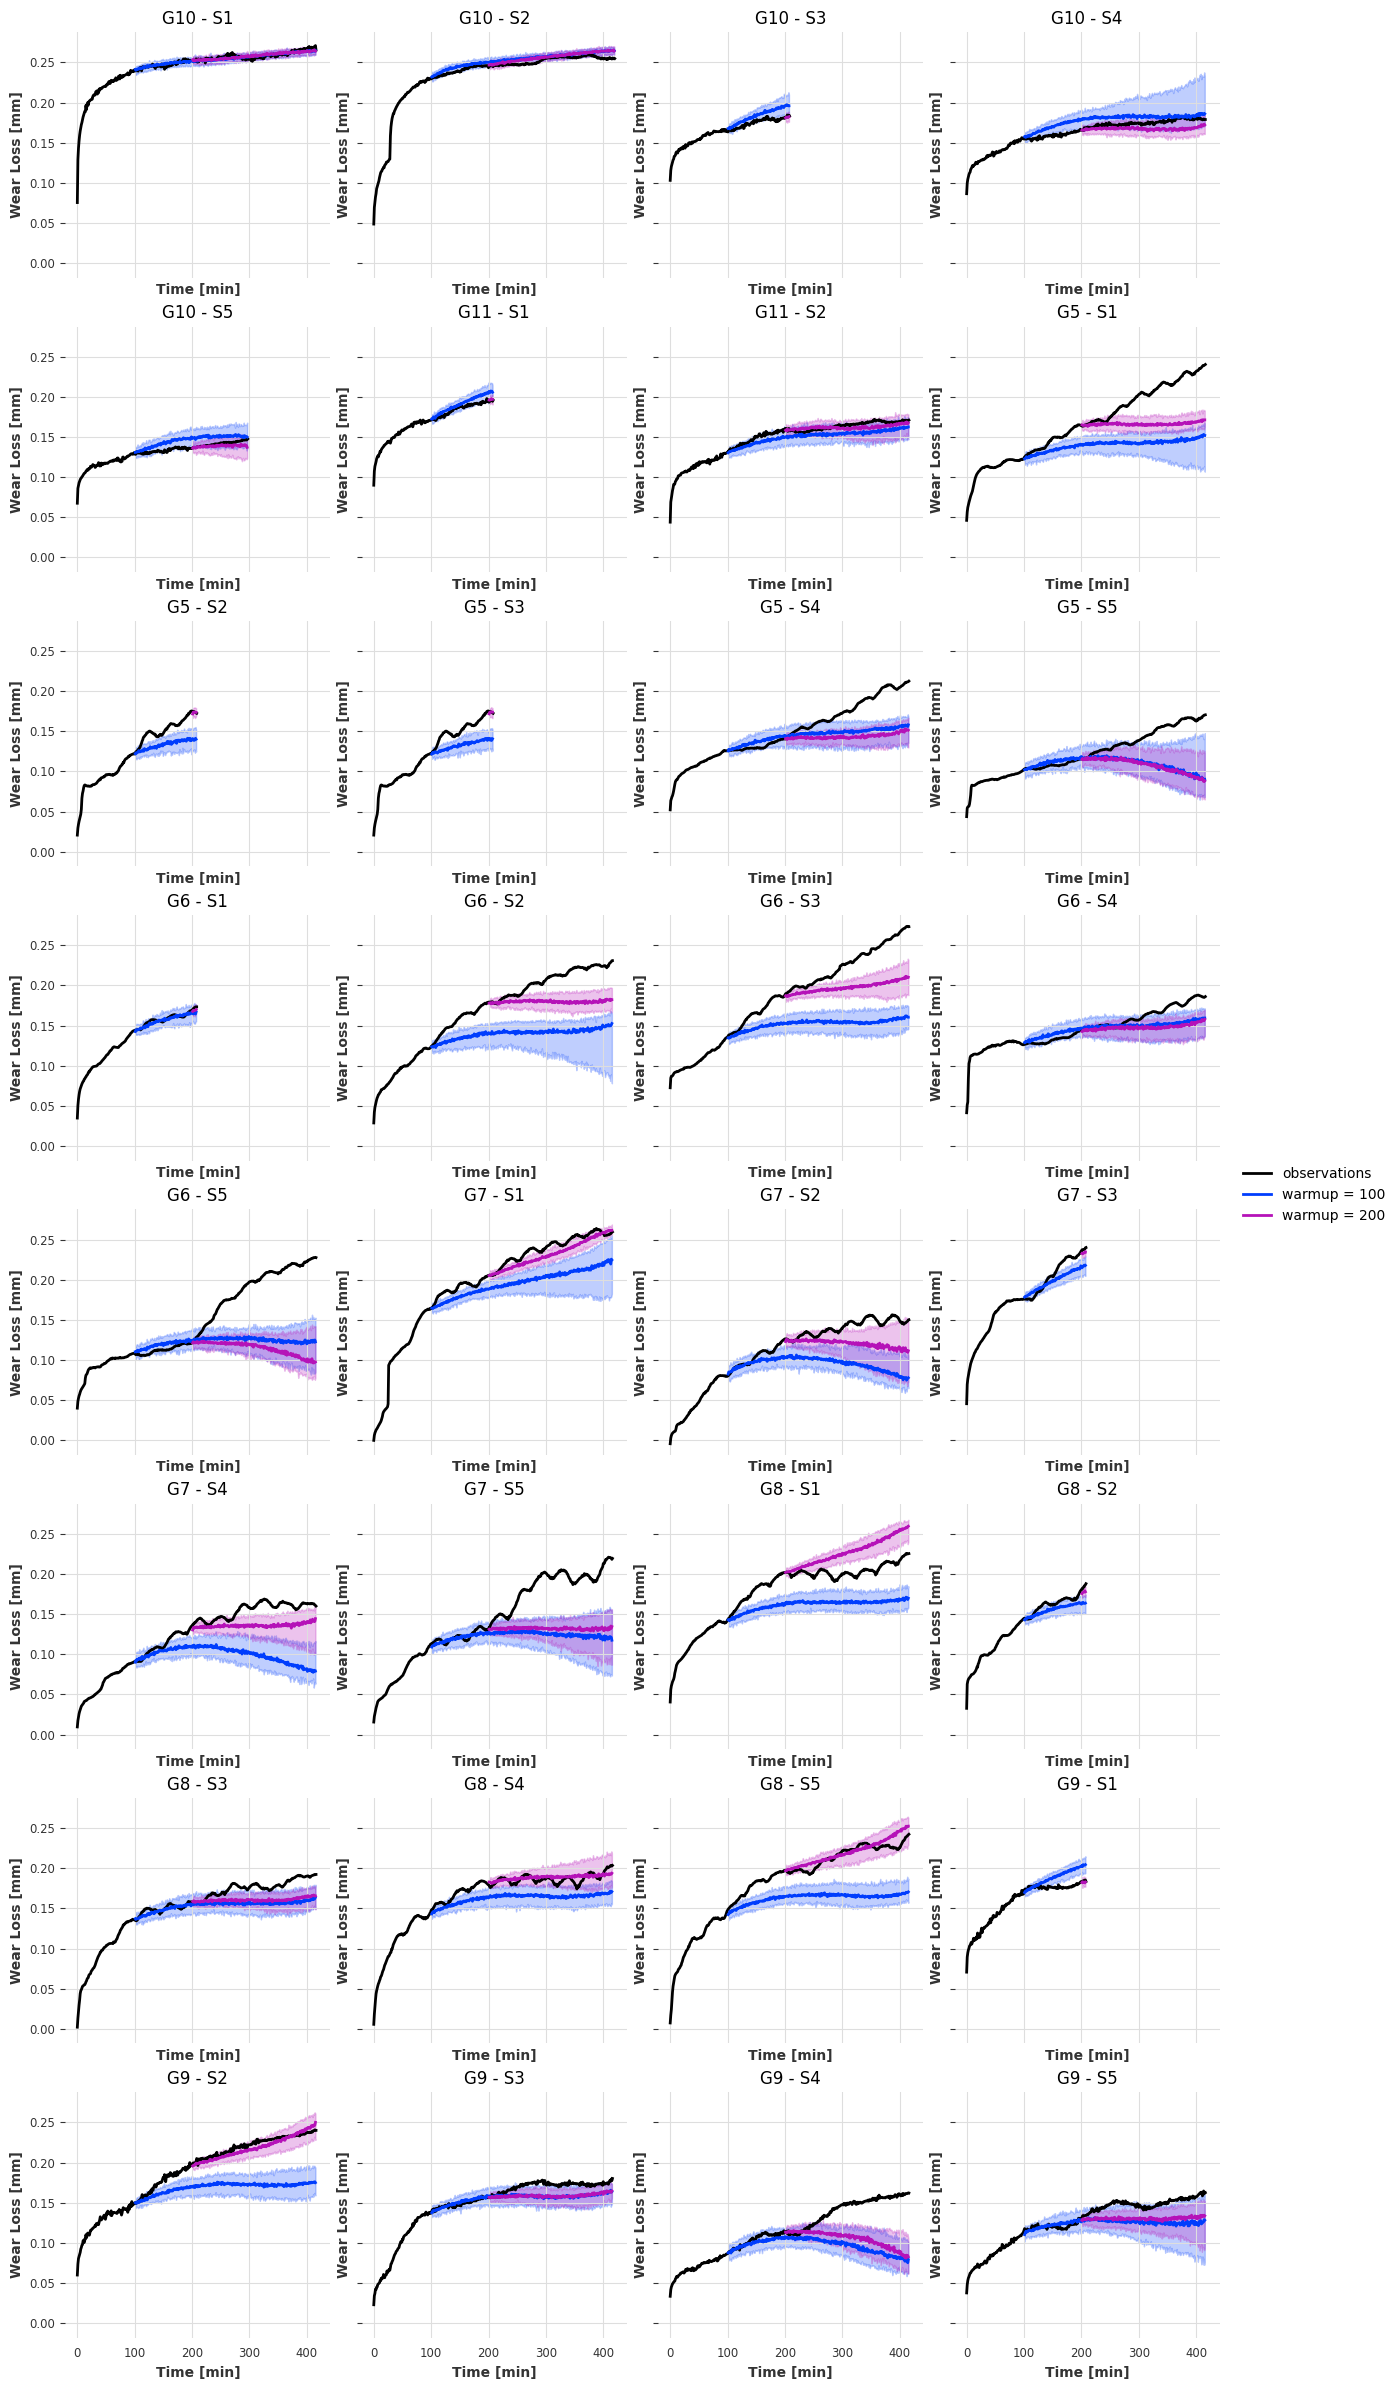

In [13]:
_ = plot_forecasts(forecasts, n_warmup, n_col=4)